In [38]:
# The test sentences are based on sentence with index 0 and 4 from the treebank used by NLTK
# Importantly, they cannot contain words not included in the treebank, otherwise the chart parser will fail.
test_sentences = [ 
    ['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'],
    ['Mrs.', 'Barnum', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'],
    ['Mr.', 'Barnum', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'],
    ['Mr.', 'Vinken', 'is', 'president', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'],
    ['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Apple', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'],
    ['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'U.S.', 'publishing', 'group', '.'],
    ['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'financial', 'company', '.'],
    ['The', 'top', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.'],
    ['The', 'good', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.'],
    ['The', 'top', 'investment', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.'],
    ['The', 'top', 'money', 'companies', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.'],
    ['The', 'top', 'money', 'funds', 'are', 'currently', 'making', 'well', 'over', '9', '%', '.'],
    ['The', 'top', 'money', 'funds', 'are', 'currently', 'yielding', 'just', 'over', '9', '%', '.'],
    ['The', 'top', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'below', '9', '%', '.'],
]

In [3]:
from parsing.data_structures.const_tree import Node, Production, ConstituencyTree
from parsing.algorithms.cd_const_dynamic_program import compute_num_matching_subtrees_dp
from parsing.const_tree_models.data_generator import transform_nltk_trees
from parsing.const_tree_models.helpers.modeling_helpers import prepare_dataset

from nltk.corpus import treebank
from nltk import Nonterminal, induce_pcfg
from nltk.tree import Tree
from nltk.parse import pchart

from sentence_transformers import SentenceTransformer


import autograd.numpy as np
from autograd import grad
from random import seed, shuffle, sample, randrange
from scipy.spatial.distance import squareform

from GPy.kern.src.kern import Kern
from GPy.core import Param
from GPy.models import GPClassification

import seaborn as sb
import matplotlib.pyplot as plt

In [4]:
# Kernel class

class Custom_GPY(Kern):

    def __init__(self, input_dim, lamb, e, active_dims=None):
        super(Custom_GPY, self).__init__(input_dim, active_dims, 'custom')

        self.lamb = Param('lamb', lamb)
        self.lamb.constrain_positive()

        self.emb_scale = Param('emb_scale', e)
        self.emb_scale.constrain_positive()

        self.link_parameters(self.lamb, self.emb_scale)

    def K(self, X, X2):
        """
        Compute the full kernel matrix

        :param X: np.array
        :param X2: np.array
        :return: np.array
        """
        n = X.shape[0]

        if X2 is None: # Symmetric case

            # Compute the upper triangular values
            vec = np.empty(shape=n * (n - 1) // 2)
            k = 0
            for i in range(n - 1):
                for j in range(i + 1, n):
                    vec[k] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X[j, 0], lamb=self.lamb)
                    k += 1

            # Create a symmetric matrix from the upper triangular values (still has 0's on the main diagonal)
            CD = squareform(vec)

            # Compute the main diagonal
            CD_diag = np.empty(n)
            for i in range(n):
                CD_diag[i] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X[i, 0], lamb=self.lamb)

            # Add the main diagonal to get the final Collins & Duffy matrix
            CD = CD + np.diag(CD_diag)

            # Calculate the embeddings matrix
            self.E_symm = self.emb_scale * np.array(np.matmul(X[:, 1:], X[:, 1:].T), dtype=np.float32)

            # Combine the C&D matrix with the embeddings matrix
            K = CD + self.E_symm

        else: # Non-symmetric case

            n2 = X2.shape[0]

            # Calculate the Collins & Duffy matrix
            CD = np.empty((n, n2))

            for i in range(n):
                for j in range(n2):
                    CD[i, j] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X2[j, 0], lamb=self.lamb)

            # Calculate the embeddings matrix
            self.E_asymm = self.emb_scale * np.array(np.matmul(X[:, 1:], X2[:, 1:].T), dtype=np.float32)

            # Combine the C&D matrix with the embeddings matrix
            K = CD + self.E_asymm

        return K

    def Kdiag(self, X):
        """
        Compute the main diagonal of the kernel matrix

        :param X: np.array
        :return: np.array (1-dim)
        """
        n = X.shape[0]
        CD_diag = np.empty(n)
        E_diag = np.empty(n)
        for i in range(n):
            CD_diag[i] = compute_num_matching_subtrees_dp(t1=X[i, 0], t2=X[i, 0], lamb=self.lamb)
            E_diag[i] = self.emb_scale * np.dot(X[i, 1:], X[i, 1:])

        return CD_diag + E_diag

    def update_gradients_full(self, dL_dK, X, X2):
        """
        Compute the gradient of the loss function w.r.t the hyperparameters.

        :param dL_dK: np.array
        :param X: np.array
        :param X2: np.array
        :return: None
        """
        n = X.shape[0]

        # Set up the derivative of the C&D dynamic program w.r.t lambda
        part_deriv = grad(compute_num_matching_subtrees_dp, 2)

        if X2 is None:

            # Compute the upper triangular values of the dK/dlambda
            vec = np.empty(shape=n * (n - 1) // 2)
            k = 0
            for i in range(n - 1):
                for j in range(i + 1, n):
                    vec[k] = part_deriv(X[i, 0], X[j, 0], self.lamb*1)
                    k += 1

            # Create a symmetric matrix from the upper triangular values (still has 0's on the main diagonal)
            dlambda = squareform(vec)

            # Compute the main diagonal
            dlambda_diag = np.empty(n)
            for i in range(n):
                dlambda_diag[i] = part_deriv(X[i, 0], X[i, 0], self.lamb*1)

            # Add the main diagonal to get the final derivative
            dlambda = dlambda + np.diag(dlambda_diag)

            # Compute dL/demb_scale
            dE = self.E_symm / self.emb_scale
            self.emb_scale.gradient = np.sum(dE * dL_dK)

        else:

            n2 = X2.shape[0]

            # Evaluate the derivative at every element of the kernel matrix
            dlambda = np.empty((n, n2))
            for i in range(n):
                for j in range(n2):
                    dlambda[i, j] = part_deriv(X[i, 0], X2[j, 0], self.lamb*1)

            # Compute dL/demb_scale
            dE = self.E_asymm / self.emb_scale
            self.emb_scale.gradient = np.sum(dE * dL_dK)

        # Compute dL/dlambda
        self.lamb.gradient = np.sum(dlambda * dL_dK)

In [40]:
# Functions

def generate_test_parse_trees_and_test_embeddings(grammar, test_sentences):
    """
    Generate most likely parses (can be thought of as true parses), worse candidate parses and embeddings for test purposes

    :return: 3-tuple of np.arrays
    """
    # Set up fastest parser in NLTK (= beam search)
    parser = pchart.InsideChartParser(grammar, beam_size=2000)

    # Set up sentence embedder
    model = SentenceTransformer('paraphrase-distilroberta-base-v1')

    # Number of candidate trees
    c = 5

    # Initialize the lists
    num_sentences = len(test_sentences)

    true_parses = [] # it can't be known in advance how many true_parses there will be (bec. only the ones with at least 5 cand parses are considered)
    parses = []
    embeddings = []

    for sent_ind in range(num_sentences):

        #true_parse = Tree.convert(tree=next(parser.parse(test_sentences[sent_ind])))
        
        for best_parse in parser.parse(test_sentences[sent_ind]):
            true_parse = Tree.convert(tree=best_parse)
            break
        
        cand_parses = []

        count = 0

        # Take the c worst parses
        for ind, parse in enumerate(reversed(list(parser.parse(test_sentences[sent_ind])))):  # Reversing the list very expensive, maybe can pop
            if count > (c - 1):
                break
            if parse != true_parse:
                cand_parses.append(Tree.convert(tree=parse)) # Convert probabilistic tree into tree
                count += 1

        if len(cand_parses) == c:  # Checks if there are 5 candidate parses (could be more flexible maybe)
            # TO-DO: make the following cells flexible enough to support different lengths of cands

            # Print the current sentence that is actually included into the dataset
            print(test_sentences[sent_ind])

            # True parses and embeddings
            true_parses.append(true_parse)
            embeddings.append(model.encode("".join(test_sentences[sent_ind])))

            # Candidate parses for the given observation
            parses.append(cand_parses)

    return true_parses, parses, embeddings


def fit_model(data, train_sent):
    """
    Fit a GPClassification model based on the train_sent

    :param data: list of np.arrays
    :param sent_inds: list of int
    :return: tuple of np.arrays
    """
    X_train, y_train = prepare_dataset(data=data, sent_inds=train_sent)
    
    kernel = Custom_GPY(input_dim=X_train.shape[1],lamb=0.5122493885645022, e=0.019017003926375585) # average values from optimized model on 50 observations
    return GPClassification(X=X_train, Y=y_train.reshape(-1, 1), kernel=kernel)


def convert_into_corr_mat(cov_mat):
    """
    Convert a covariance matrix into a correlation matrix
    
    :param sent_inds: np.array
    :return: np.array
    """
    n = cov_mat.shape[0]
    upper_triang = np.empty(shape=n * (n - 1) // 2)
    k = 0
    for i in range(n - 1):
        for j in range(i + 1, n):
            upper_triang[k] = cov_mat[i,j]/(np.sqrt(cov_mat[i,i])*np.sqrt(cov_mat[j,j]))
            k += 1

    # Create a symmetric matrix from the upper triangular values (still has 0's on the main diagonal)
    corr = squareform(upper_triang)
    corr = corr + np.diag(np.ones(n))
    
    return corr

In [13]:
# Parameters
SMALL_TRAIN_SENTENCES = 50
LARGE_TRAIN_SENTENCES = 200

In [14]:
# Sentences of small training data set and big training data set
small_sent_train = list(range(SMALL_TRAIN_SENTENCES+2))
large_sent_train = list(range(LARGE_TRAIN_SENTENCES+2))

# Remove the sentences the test set is based on
small_sent_train.remove(0)
small_sent_train.remove(4)

large_sent_train.remove(0)
large_sent_train.remove(4)

In [15]:
# Load the training data (assuming they were already generated - run save_model and place in directory first)
true_parses_train = np.load("true_parses.npy", allow_pickle=True)
cand_parses_train = np.load("cand_parses.npy", allow_pickle=True)
embeddings_train = np.load("embeddings.npy", allow_pickle=True)

small_data = [true_parses_train[:SMALL_TRAIN_SENTENCES+2], cand_parses_train[:SMALL_TRAIN_SENTENCES+2], embeddings_train[:SMALL_TRAIN_SENTENCES+2]]
large_data = [true_parses_train[:LARGE_TRAIN_SENTENCES+2], cand_parses_train[:LARGE_TRAIN_SENTENCES+2], embeddings_train[:LARGE_TRAIN_SENTENCES+2]]

In [16]:
# Train the models
small_model = fit_model(data=small_data, train_sent=small_sent_train)
large_model = fit_model(data=large_data, train_sent=large_sent_train)

 c:\users\flori\anaconda3\envs\mt\lib\site-packages\autograd\tracer.py:14: UserWarning:Output seems independent of input.


In [17]:
# In order to build the test set, we first need to come up with a grammar from the treebank
productions = []
for item in treebank.fileids():
    
    tree_sent_pairs = zip(treebank.sents(item), treebank.parsed_sents(item))

    for sent, tree in tree_sent_pairs:  # iterate through all sentences and trees from each file
        
        if len(sent) < 15:  # Only take sentences of length < 15 to ensure different parses

            # Bring trees in CNF
            tree.collapse_unary(collapsePOS=True)  # Remove branches A-B-C into A-B+C
            tree.chomsky_normal_form()  # Remove A->(B,C,D) into A->B,C+D->D

            # Keep track of productions to produce the PCFG
            productions += tree.productions()

S = Nonterminal("S")
grammar = induce_pcfg(S, productions)

In [41]:
# Given a grammar and test sentences, build the test parses and embeddings
true_parses_test, parses_test, embeddings_test = generate_test_parse_trees_and_test_embeddings(grammar=grammar, test_sentences=test_sentences)

['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Mrs.', 'Barnum', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Mr.', 'Barnum', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Mr.', 'Vinken', 'is', 'president', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Apple', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.']
['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'U.S.', 'publishing', 'group', '.']
['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'financial', 'company', '.']
['The', 'top', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.']
['The', 'good', 'money', 'funds', 'are', 'currently', 'yielding', 'well', 'over', '9', '%', '.']
['The', 'top', 'investment', 'f

In [21]:
# Convert the true parses and candidate parses into the custom data structure ConstituencyTree
new_true_trees_test = transform_nltk_trees(true_parses_test)

new_cands_lists_test = np.empty(shape=len(true_parses_test), dtype=object)
for ind, cands in enumerate(parses_test):
    new_cands_lists_test[ind] = transform_nltk_trees(cands)

new_embeddings_test = np.array(embeddings_test, dtype=object)

data_test = [new_true_trees_test, new_cands_lists_test, new_embeddings_test]

In [22]:
# Build the test set
X_test, y_test = prepare_dataset(data=data_test, sent_inds=list(range(len(true_parses_test))))

In [23]:
# Investigate the covariance matrix
# Extract the covariance matrix of the sentences in the test set
post_mu_small, post_var_small = small_model._raw_predict(X_test, full_cov=True)
post_mu_large, post_var_large = large_model._raw_predict(X_test, full_cov=True)

In [24]:
# Convert into correlation matrix
post_cor_small = convert_into_corr_mat(post_var_small)
post_cor_large = convert_into_corr_mat(post_var_large)

<AxesSubplot:>

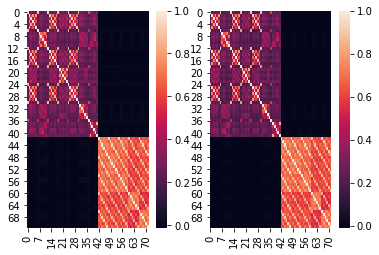

In [25]:
# All test samples -> Conclusion: See the two clusters stemming from two different slightly changed sentences
fig, ax = plt.subplots(1,2)
sb.heatmap(post_cor_small, ax=ax[0])
sb.heatmap(post_cor_large, ax=ax[1])

<AxesSubplot:>

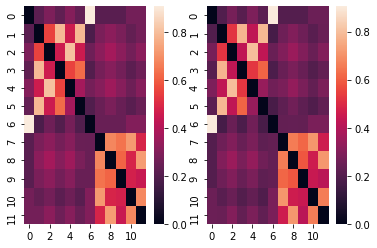

In [28]:
# Set the main diagonal to zero to make correlations more visible
post_cor_small_no_diag = post_cor_small.copy()
post_cor_large_no_diag = post_cor_large.copy()
np.fill_diagonal(post_cor_small_no_diag, 0)
np.fill_diagonal(post_cor_large_no_diag, 0)

# Plot slightly less points to better observe that correlations within similar sentences are high but 
# between the two sentence blocks are low

fig, ax = plt.subplots(1,2)
sb.heatmap(post_cor_small_no_diag[:12,:12], ax=ax[0]) # 7 sentences (i.e. true parse and 5 cands) of first cluster and 3 (i.e. true parse and 5 cands) of second
sb.heatmap(post_cor_large_no_diag[:12,:12], ax=ax[1])

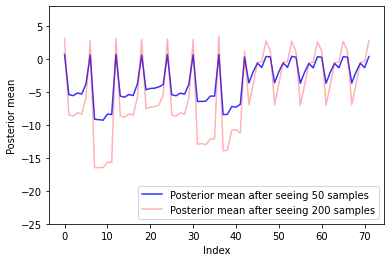

In [27]:
# Investigate the mean function

plt.plot(post_mu_small, 'b-', alpha=0.8)
plt.plot(post_mu_large, 'r-', alpha=0.3)
plt.ylim([-25, 8])
plt.ylabel("Posterior mean")
plt.xlabel("Index")
plt.legend(["Posterior mean after seeing 50 samples", "Posterior mean after seeing 200 samples"], loc="lower right")

# Histogram?

# Ratio von rot zu blau für jeden Index berechnen und dann mean bilden

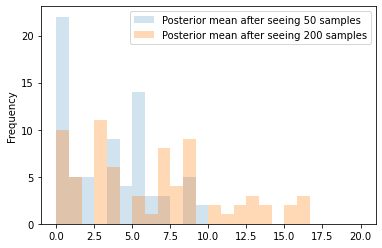

In [48]:
# One can see that higher posterior mean values (in absolute value) are much more common for the model based on 200 samples

bins = np.linspace(0, 20, 25)

plt.hist(np.abs(post_mu_small),bins,alpha=0.2, label='Posterior mean after seeing 50 samples')
plt.hist(np.abs(post_mu_large),bins,alpha=0.3, label='Posterior mean after seeing 200 samples')
plt.ylabel("Frequency")
plt.legend(loc='upper right')

In [36]:
# On average, the posterior mean after seeing 200 samples is 138% higher than the posterior mean after seeing 50 samples.
# Even though the covariance does not change, if the posterior mean is further from 0, sampling will lead to consistently
# positive or negative values, which once squeezed through the sigmoid, will lead to clearer decisions

np.mean(post_mu_large/post_mu_small)

2.38019294511078